# Offline RL (80 Points)

> Name: Aylin Rasteh

> SID: 400104964




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
from torch.optim import Adam


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [4]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
         
        # Define your network layers
        ##########################################################
        self.fc1 = nn.Linear(input_dimension, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dimension)
        self.output_activation = output_activation

    def forward(self, inpt):
        output = None
        ##########################################################
         
        # Calculate the output
        ##########################################################
        x = F.relu(self.fc1(inpt))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = self.output_activation(x)
        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [5]:
import numpy as np

class ReplayBuffer:
    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, float32'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [6]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-3, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        ##########################################################
         
        # Define critics usig your implemented feed forward netwrok
        ##########################################################
        self.critic_local = Network(self.state_dim, 1)
        self.critic_local2 = Network(self.state_dim, 1)
        self.critic_optimiser = Adam(self.critic_local.parameters(), lr=self.learning_rate)
        self.critic_optimiser2 = Adam(self.critic_local2.parameters(), lr=self.learning_rate)
        self.critic_target = Network(self.state_dim, 1)
        self.critic_target2 = Network(self.state_dim, 1)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
         
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(self.state_dim, self.action_dim, output_activation=torch.nn.Softmax(dim=-1))
        self.actor_optimiser  = Adam(self.actor_local.parameters(), lr=self.learning_rate)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
#         print(action_probabilities)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
         
        # You are going to calculate critic losses in this method
        ##########################################################
        probs_next_actions, log_probs_next_actions = self.get_action_info(states_tensor)
        log_probs_next_actions = log_probs_next_actions.gather(1, actions_tensor.unsqueeze(1)).view(-1)
#         print("actions_tensor:", actions_tensor.shape)

        target_q_values1 = self.critic_target(next_states_tensor).view(-1)
        target_q_values2 = self.critic_target2(next_states_tensor).view(-1)
        target_q_values = rewards_tensor + self.discount * (1 - done_tensor) * (torch.min(target_q_values1, target_q_values2) - self.alpha * log_probs_next_actions)
#         print("target_q_values1:", target_q_values1.shape)
#         print("target_q_values2:", target_q_values2.shape)
        current_q_values1 = self.critic_local(states_tensor).view(-1)
        current_q_values2 = self.critic_local2(states_tensor).view(-1)

        critic_loss1 = F.mse_loss(current_q_values1, target_q_values)
        critic_loss2 = F.mse_loss(current_q_values2, target_q_values)

        return critic_loss1, critic_loss2
        ##########################################################

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
         
        # Implement the actor loss
        ##########################################################
        probs_next_actions, log_probs_next_actions = self.get_action_info(states_tensor)

        log_probs_next_actions = log_probs_next_actions.gather(1, actions_tensor.unsqueeze(1)).view(-1)

        q_values1 = self.critic_local(states_tensor)
        q_values2 = self.critic_local2(states_tensor)

        actor_loss_value = (self.alpha * log_probs_next_actions - torch.min(q_values1, q_values2).view(-1)).mean()

        return actor_loss_value, log_probs_next_actions

        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
         
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()

        if not self.offline and transition is not None:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
             
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it
            # You also need to update \alpha
            ##########################################################

            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward(retain_graph=True)
            critic2_loss.backward(retain_graph=True)
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor, actions_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()
#             print(critic_loss, critic2_loss, actor_loss, alpha_loss)

            self.soft_update_target_networks(self.interpolation_factor)


    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
#         print(action_probabilities.squeeze(0).detach().numpy(), state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

Run 1/1
Episode 4/200 - Evaluation Mean: 9.20, Std: 0.40, Total: [10.0, 9.0, 9.0, 9.0, 9.0]
Episode 8/200 - Evaluation Mean: 9.80, Std: 0.75, Total: [10.0, 9.0, 11.0, 9.0, 10.0]
Episode 12/200 - Evaluation Mean: 10.00, Std: 0.89, Total: [9.0, 9.0, 11.0, 10.0, 11.0]
Episode 16/200 - Evaluation Mean: 12.60, Std: 2.06, Total: [11.0, 13.0, 13.0, 10.0, 16.0]
Episode 20/200 - Evaluation Mean: 102.00, Std: 49.90, Total: [119.0, 61.0, 79.0, 192.0, 59.0]
Episode 24/200 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 28/200 - Evaluation Mean: 140.20, Std: 31.54, Total: [107.0, 200.0, 131.0, 137.0, 126.0]
Episode 32/200 - Evaluation Mean: 188.20, Std: 20.28, Total: [148.0, 193.0, 200.0, 200.0, 200.0]
Episode 36/200 - Evaluation Mean: 140.60, Std: 19.15, Total: [135.0, 122.0, 121.0, 155.0, 170.0]
Episode 40/200 - Evaluation Mean: 169.00, Std: 28.65, Total: [172.0, 122.0, 200.0, 155.0, 196.0]
Episode 44/200 - Evaluation Mean: 128.40, Std: 25.59, Total: [101.

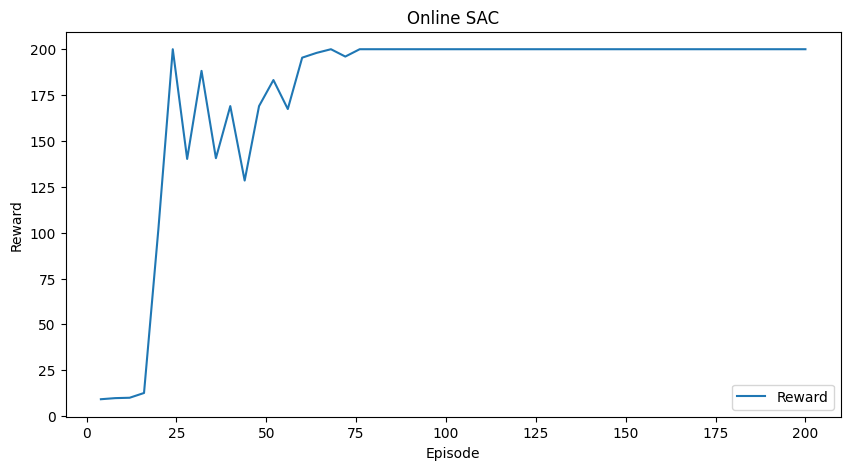

In [16]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 200
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")
NUM_RUNS = 1
##########################################################
 
# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################

def evaluate_agent(agent, env, steps_per_episode, episodes=5):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        for step in range(steps_per_episode):
            action = agent.get_next_action(state, evaluation_episode=True)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
            if done:
                break
        total_rewards.append(episode_reward)
    return total_rewards, np.mean(total_rewards), np.std(total_rewards)

def train_and_evaluate(agent, env, training_evaluation_ratio, episodes_per_run, steps_per_episode):
    training_rewards = []
    evaluation_rewards = []
    evaluation_means = []
    evaluation_stds = []

    for episode in range(episodes_per_run):
        state = env.reset()
        episode_reward = 0
        for step in range(steps_per_episode):
            action = agent.get_next_action(state)
            next_state, reward, done, _ = env.step(action)
#             print(next_state, state, action, reward)
            agent.train_on_transition(state, action, next_state, reward, done)
            episode_reward += reward
            state = next_state
            if done:
                break

        training_rewards.append(episode_reward)

        if (episode + 1) % training_evaluation_ratio == 0:
            eval_rewards,eval_mean, eval_std = evaluate_agent(agent, env, steps_per_episode)
            evaluation_rewards.append(eval_rewards)
            evaluation_means.append(eval_mean)
            evaluation_stds.append(eval_std)
            print(f"Episode {episode + 1}/{episodes_per_run} - Evaluation Mean: {eval_mean:.2f}, Std: {eval_std:.2f}, Total: {eval_rewards}")

    return training_rewards, evaluation_rewards, evaluation_means, evaluation_stds

all_training_rewards = []
all_evaluation_rewards = []
all_evaluation_means = []
all_evaluation_stds = []

for run in range(NUM_RUNS):
    print(f"Run {run + 1}/{NUM_RUNS}")
    sac_agent = SACAgent(env)
    training_rewards, evaluation_rewards, eval_means, eval_stds = train_and_evaluate(sac_agent, env, TRAINING_EVALUATION_RATIO, EPISODES_PER_RUN, STEPS_PER_EPISODE)
    all_training_rewards.append(training_rewards)
    all_evaluation_rewards.append(evaluation_rewards)
    all_evaluation_means.append(eval_means)
    all_evaluation_stds.append(eval_stds)

all_training_rewards = np.array(all_training_rewards)
all_evaluation_rewards = np.array(evaluation_rewards)
all_evaluation_means = np.array(all_evaluation_means)
all_evaluation_stds = np.array(all_evaluation_stds)


x_values = np.arange(1, len(all_evaluation_means[0]) + 1) * TRAINING_EVALUATION_RATIO
np.save("replay_buffer.npy", sac_agent.replay_buffer.buffer)

plt.figure(figsize=(10, 5))
plt.plot(x_values, all_evaluation_means[0], label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Online SAC')
plt.legend()
plt.show()


In [18]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []
total_reward = 0

state = env.reset()
for _ in range(200):
    frames.append(env.render()[0])
    action = sac_agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break

print(total_reward)
env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

200.0


In [ ]:
!pip install gym[classic_control]
!pip install imageio==2.19.3
!pip install imageio-ffmpeg==0.4.7

## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

Episode 4/100 - Evaluation Mean: 147.00, Std: 57.16, Total: [60.0, 98.0, 181.0, 200.0, 196.0]
Episode 8/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 12/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 16/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 20/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 24/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 28/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 32/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 36/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 40/100 - Evaluation Mean: 200.00, Std: 0.00, Total: [200.0, 200.0, 200.0, 200.0, 200.0]
Episode 44/100 - Evaluation Mean: 200.00, S

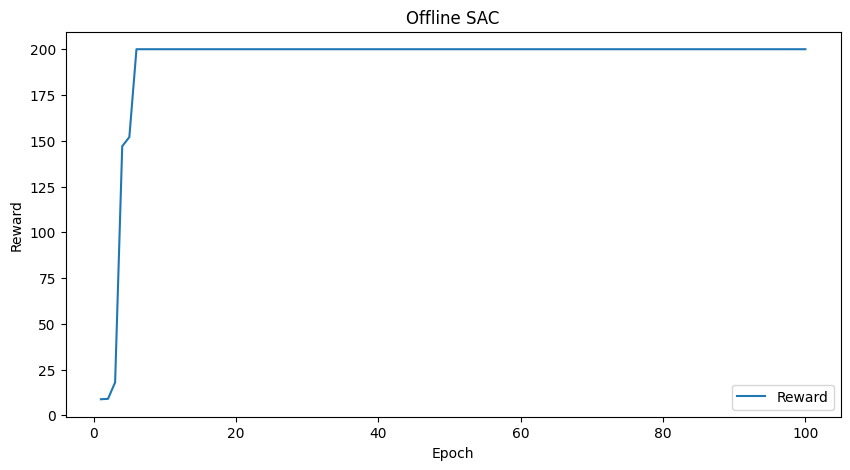

In [35]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
 
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################

def train_and_evaluate_offline(agent, env, training_evaluation_ratio, num_epochs, episodes_per_run, steps_per_episode):
    training_rewards = []
    evaluation_rewards = []
    evaluation_means = []
    evaluation_stds = []


    for episode in range(episodes_per_run):
        for epoch in range(NUM_EPOCHS):
            agent.train_networks()

        eval_rewards, eval_mean, eval_std = evaluate_agent(agent, env, steps_per_episode)
        evaluation_rewards.append(eval_rewards)
        evaluation_means.append(eval_mean)
        evaluation_stds.append(eval_std)

        if (episode + 1) % training_evaluation_ratio == 0:
            print(f"Episode {episode + 1}/{episodes_per_run} - Evaluation Mean: {eval_mean:.2f}, Std: {eval_std:.2f}, Total: {eval_rewards}")

    return training_rewards, evaluation_rewards, evaluation_means, evaluation_stds


# replay_buffer_data = np.load("replay_buffer.npy", allow_pickle=True)
# replay_buffer = ReplayBuffer(env)
# replay_buffer.buffer = replay_buffer_data
# replay_buffer.count = len(replay_buffer_data)

replay_buffer = sac_agent.replay_buffer
offline_sac_agent = SACAgent(env, replay_buffer=replay_buffer, offline=True)
training_rewards, evaluation_rewards, eval_means, eval_stds = train_and_evaluate_offline(offline_sac_agent, env, TRAINING_EVALUATION_RATIO, NUM_EPOCHS, EPISODES_PER_RUN, STEPS_PER_EPISODE)

x_values = np.arange(1, len(eval_means) + 1)

plt.figure(figsize=(10, 5))
plt.plot(x_values, eval_means, label='Reward')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Offline SAC')
plt.legend()
plt.show()

In [39]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []
total_reward = 0

state = env.reset()
for _ in range(200):
    frames.append(env.render()[0])
    action = offline_sac_agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break

print(total_reward)
env.close()
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

200.0


 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [37]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

 
# Collect state-action pairs

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    done = False
    while not (done):
        action = sac_agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, done, _ = env.step(action)
        expert_data.append((state, action))
        state = next_state

expert_data = np.array(expert_data, dtype=object)
np.save("expert_data.npy", expert_data)

100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Define the model for behaviuoral cloning.

In [40]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
         
        # Define the model
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
         
        # Perform forward pass
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [51]:
def load_expert_data(file_path):
    expert_data = np.load(file_path, allow_pickle=True)
    states = np.vstack(expert_data[:, 0])
    actions = np.array(expert_data[:, 1], dtype=int)
    return states, actions

def train_bc_model(model, criterion, optimizer, states, actions, num_epochs, batch_size):
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)

    for epoch in range(num_epochs):
        total_loss = 0
        permutation = torch.randperm(states.size()[0])

        for i in range(0, states.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_states, batch_actions = states[indices], actions[indices]

            optimizer.zero_grad()
            outputs = model(batch_states)
            loss = criterion(outputs, batch_actions)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (states.size()[0] // batch_size)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}')

file_path = "expert_data.npy"
states, actions = load_expert_data(file_path)

input_dimension = states.shape[1]
hidden_dimension = 128
output_dimension = env.action_space.n
learning_rate = 1e-3
num_epochs = 15
batch_size = 64

bc_model = BCModel(input_dimension, hidden_dimension, output_dimension)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bc_model.parameters(), lr=learning_rate)

train_bc_model(bc_model, criterion, optimizer, states, actions, num_epochs, batch_size)

torch.save(bc_model.state_dict(), "bc_model.pth")

Epoch 1/15, Loss: 1447.7942235115916
Epoch 2/15, Loss: 427.5805440293625
Epoch 3/15, Loss: 273.9605039296439
Epoch 4/15, Loss: 217.65268638858106
Epoch 5/15, Loss: 184.66179944758187
Epoch 6/15, Loss: 164.3243040944617
Epoch 7/15, Loss: 149.4867244035322
Epoch 8/15, Loss: 138.04938001578012
Epoch 9/15, Loss: 130.56671008762464
Epoch 10/15, Loss: 122.5742626044439
Epoch 11/15, Loss: 117.68544448793
Epoch 12/15, Loss: 112.52546281715718
Epoch 13/15, Loss: 108.01840596377815
Epoch 14/15, Loss: 103.71823613331375
Epoch 15/15, Loss: 101.9607957904854


Evaluate and render the results.

In [52]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []
total_reward = 0

state = env.reset()
for _ in range(200):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = bc_model(state)
    action = torch.argmax(action_probs, dim=1).item()
    state, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
print(total_reward)
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

200.0
